This project forecasts Apple stock prices using four models: ARIMA, SARIMA, XGBoost, and LSTM.

It compares model performance using metrics like RMSE and selects the best one for 30-day forecasting.

The workflow includes data preprocessing, visualization, modeling, evaluation, and future prediction.


**Importing Libraries**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# Deep Learning (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

Loads essential libraries for data handling, visualization, time series modeling, machine learning, and deep learning.

Suppresses warnings for cleaner output and sets up LSTM layers for neural network modeling.


**Load and Prepare Dataset**

In [2]:
df = pd.read_csv("P587 DATASET.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)
df = df.fillna(method='ffill')

 Reads the Apple stock dataset and converts the 'Date' column to datetime format.

 Sorts by date, sets it as index, and fills missing values using forward fil


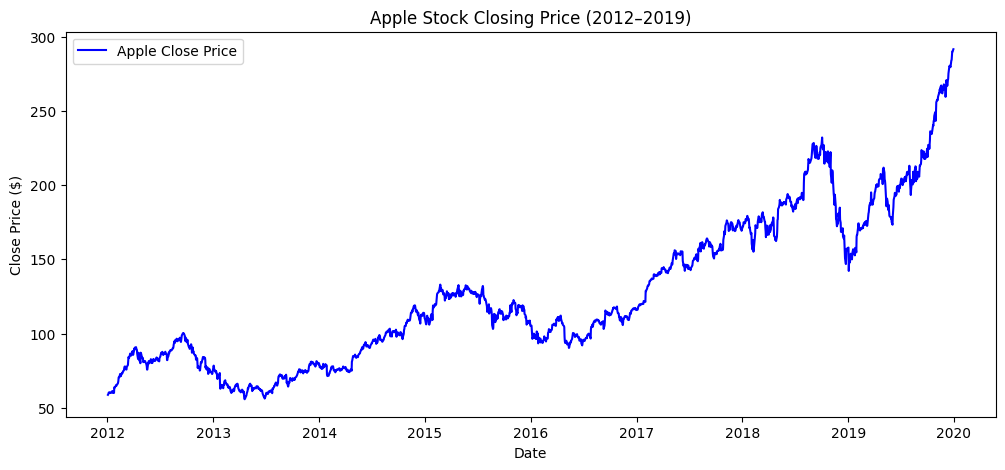

In [3]:
plt.figure(figsize=(12,5))
plt.plot(df['Close'], label='Apple Close Price', color='blue')
plt.title('Apple Stock Closing Price (2012–2019)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

Visualizes the historical closing price to understand trends.

Helps identify patterns, seasonality, or anomalies in the data.


**Time series Split**

In [4]:
train_size = int(len(df) * 0.9)
train, test = df['Close'][:train_size], df['Close'][train_size:]

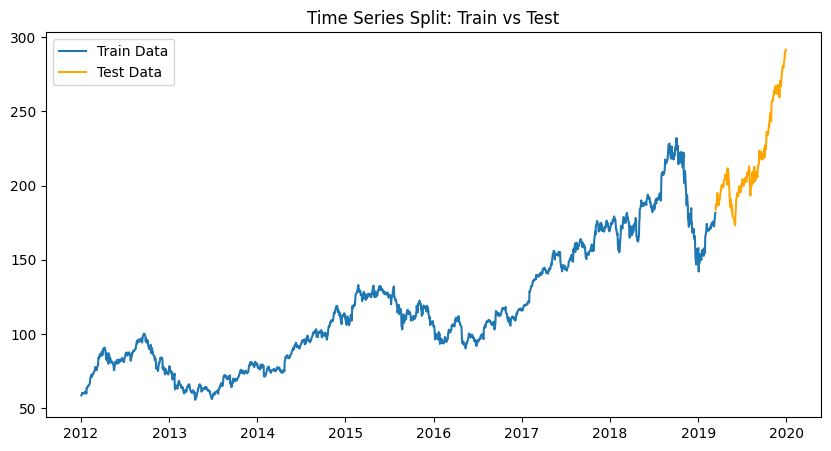

In [5]:
plt.figure(figsize=(10,5))
plt.plot(train, label='Train Data')
plt.plot(test, label='Test Data', color='orange')
plt.title('Time Series Split: Train vs Test')
plt.legend()
plt.show()

**ARIMA MODEL**

In [6]:
arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
arima_pred.index = test.index

In [7]:
mse_arima = mean_squared_error(test, arima_pred)
mae_arima = mean_absolute_error(test, arima_pred)
rmse_arima = sqrt(mse_arima)
r2_arima = r2_score(test, arima_pred)


Fits ARIMA model with specified order (p=5, d=1, q=0).

Forecasts future values on the test set

Calculates performance metrics to evaluate ARIMA predictions.

Includes MSE, MAE, RMSE, and R² for comparison.


**SARIMA MODEL**

In [8]:
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)
sarima_pred = sarima_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
sarima_pred.index = test.index

In [9]:
mse_sarima = mean_squared_error(test, sarima_pred)
mae_sarima = mean_absolute_error(test, sarima_pred)
rmse_sarima = sqrt(mse_sarima)
r2_sarima = r2_score(test, sarima_pred)

Fits SARIMA model with seasonal components (monthly cycle).

Predicts test set values using seasonal autoregression.

Evaluates SARIMA predictions using standard error metrics.

Enables comparison with other models.


**XGBOOST MODEL **

In [10]:
df_ml = df.copy()
df_ml['Day'] = df_ml.index.day
df_ml['Month'] = df_ml.index.month
df_ml['Year'] = df_ml.index.year
df_ml['MA_5'] = df_ml['Close'].rolling(5).mean()
df_ml['MA_10'] = df_ml['Close'].rolling(10).mean()
df_ml = df_ml.dropna()

In [11]:
X = df_ml[['Open','High','Low','Volume','Day','Month','Year','MA_5','MA_10']]
y = df_ml['Close']
split = int(len(X)*0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Adds date-based features and moving averages for ML input.

Enhances predictive power by including temporal and trend indicators

Defines feature matrix and target variable.

Splits into training and testing sets for supervised learning.



In [12]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

Scales features to [0,1] range for better model performance.

Prevents bias due to differing feature magnitudes

Trains XGBoost model and makes predictions on test data.

Uses 500 trees and a learning rate of 0.05.



In [14]:
mse_xgb = mean_squared_error(y_test, xgb_pred)
mae_xgb = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = sqrt(mse_xgb)
r2_xgb = r2_score(y_test, xgb_pred)

Evaluates XGBoost predictions using error metrics.

Enables comparison with time series models


**LSTM MODEL**

In [15]:
data = df[['Close']]
scaler_lstm = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler_lstm.fit_transform(data)
train_size = int(len(scaled_data) * 0.9)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [16]:
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [18]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Prepares data for LSTM by scaling and splitting.

Uses only 'Close' price for sequence modeling

Creates sequences of 60 timesteps for LSTM input.

Each sample predicts the next closing price

Reshapes data to 3D format required by LSTM.

(samples, timesteps, features)


In [19]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

In [20]:
lstm_pred = model.predict(X_test)
lstm_pred = scaler_lstm.inverse_transform(lstm_pred)
y_test_actual = scaler_lstm.inverse_transform(y_test.reshape(-1,1))
mse_lstm = mean_squared_error(y_test_actual, lstm_pred)
mae_lstm = mean_absolute_error(y_test_actual, lstm_pred)
rmse_lstm = sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, lstm_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


Builds and trains LSTM model with early stopping.

Prevents overfitting and speeds up training

Makes predictions and evaluates LSTM performance.

Converts scaled values back to original price range


**MODEL COMPARISON TABLE**

In [21]:
results_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'XGBoost', 'LSTM'],
    'MSE': [mse_arima, mse_sarima, mse_xgb, mse_lstm],
    'MAE': [mae_arima, mae_sarima, mae_xgb, mae_lstm],
    'RMSE': [rmse_arima, rmse_sarima, rmse_xgb, rmse_lstm],
    'R²': [r2_arima, r2_sarima, r2_xgb, r2_lstm]
}).round(4)

Creates a DataFrame to compare all models using key metrics: MSE, MAE, RMSE, and R².

Rounds values to 4 decimal places for cleaner presentation


Display Tabular Comparison

In [22]:
print("\n MODEL PERFORMANCE COMPARISON\n")
from tabulate import tabulate
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))


 MODEL PERFORMANCE COMPARISON

╒═════════╤══════════╤═════════╤═════════╤═════════╕
│ Model   │      MSE │     MAE │    RMSE │      R² │
╞═════════╪══════════╪═════════╪═════════╪═════════╡
│ ARIMA   │ 2214.88  │ 37.0377 │ 47.0625 │ -1.5557 │
├─────────┼──────────┼─────────┼─────────┼─────────┤
│ SARIMA  │ 1562.75  │ 30.4723 │ 39.5317 │ -0.8032 │
├─────────┼──────────┼─────────┼─────────┼─────────┤
│ XGBoost │  376.356 │ 10.5462 │ 19.3999 │  0.5649 │
├─────────┼──────────┼─────────┼─────────┼─────────┤
│ LSTM    │   14.315 │  2.9645 │  3.7835 │  0.9819 │
╘═════════╧══════════╧═════════╧═════════╧═════════╛


Best model based on RMSE


In [23]:
best_model = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
print(f"\n  BEST MODEL BASED ON LOWEST RMSE: {best_model}")


  BEST MODEL BASED ON LOWEST RMSE: LSTM


Selects the model with the lowest RMSE, indicating best predictive accuracy.

Prints the winning model for future forecasting.


**VISUALIZATION**

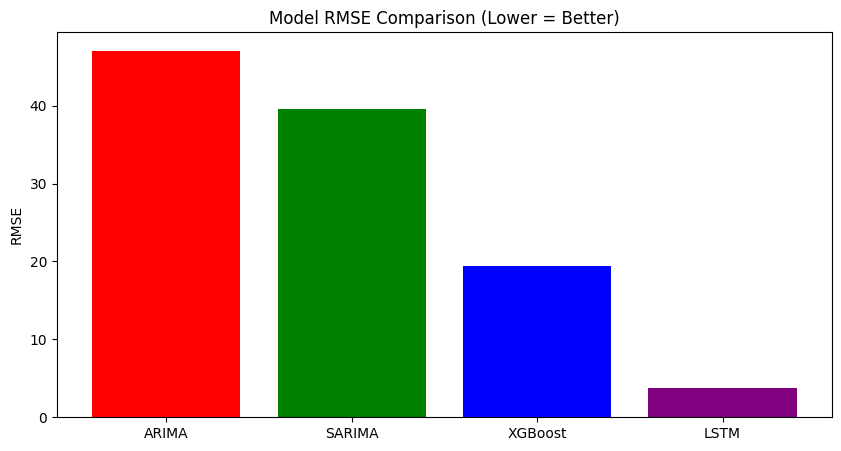

In [24]:
plt.figure(figsize=(10,5))
plt.bar(results_df['Model'], results_df['RMSE'], color=['red','green','blue','purple'])
plt.title('Model RMSE Comparison (Lower = Better)')
plt.ylabel('RMSE')
plt.show()